# Implementation of Model from https://arxiv.org/pdf/2007.03113.pdf

# Import Required Libraries

In [1]:
import haversine as hs
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import math
import torch
from torch_geometric.data import Data, Dataset
from sklearn.preprocessing import LabelEncoder
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from utils_temporal import get_distance
import warnings
warnings.filterwarnings("ignore")


df = pd.read_csv('data/final_data_mar.csv.gz')
df['time'] = pd.to_datetime(df['time'])

# Label Encoding 
First, we take a week's data from the overall dataset. Then label encode the timestamps and data, so that constructing the graph is easier.

In [2]:
df = df[(df['time'] > '2014-07-19 00:00:00') & (df['time'] < '2014-07-24 00:00:00')]

le_stations = LabelEncoder()
df['station_id'] = le_stations.fit_transform(df['station_id'])

le_time = LabelEncoder()
df['time'] = le_time.fit_transform(df['time'])

df.head()

,time,station_id,longitude,latitude,PM25_Concentration,weather,temperature,humidity,wind_speed,wind_direction,filled
1897,0,0,116.20531,40.00395,101.0,0.0,27.0,94.0,6.48,4.0,False
1898,1,0,116.20531,40.00395,112.0,0.0,26.0,96.0,3.96,4.0,False
1899,2,0,116.20531,40.00395,110.0,0.0,25.0,98.0,6.48,4.0,False
1900,3,0,116.20531,40.00395,126.0,0.0,25.0,100.0,5.40,4.0,False
1901,4,0,116.20531,40.00395,131.0,0.0,25.0,100.0,6.12,4.0,False


# Function for creating spatial graph for a timestamp

In [3]:
def spatial_graph(df, time):

    # Create an empty graph
    G = nx.Graph()

    # Iterate over each row in the dataframe
    for i in range(len(df)):
        lat1, lon1 = df.iloc[i]["latitude"], df.iloc[i]["longitude"]
        pm = df.iloc[i]["PM25_Concentration"]
        station = df.iloc[i]["station_id"]
        weather = df.iloc[i]['weather']
        wind_speed = df.iloc[i]['wind_speed']
        wind_direction = df.iloc[i]['wind_direction']
        temperature = df.iloc[i]['temperature']
        humidity = df.iloc[i]['humidity']
        
        # Add a node to the graph with attributes
        G.add_node(i+time, latitude=lat1, longitude=lon1, pm=pm, station=station, weather = weather, wind_speed = wind_speed, wind_direction = wind_direction, temperature = temperature, humidity = humidity)
        
        # Iterate over the remaining rows to check for edges
        for j in range(i + 1, len(df)):
            lat2, lon2 = df.iloc[j]["latitude"], df.iloc[j]["longitude"]
            
            # Calculate the distance between the two nodes
            distance = get_distance(lat1, lon1, lat2, lon2)
            
            # Add an edge between the nodes
            G.add_edge(i+time, j+time,weight = 1/distance)
    
    return G

# Function for Creating Spatio-Temporal Graph

The graph can be viewed as a layered graph, where the number of layers is total number of timestamps in the data. Each layer is the spatial graph for a timestamp. Each node within a layer has edges to the 7 nodes directly before it in time.  
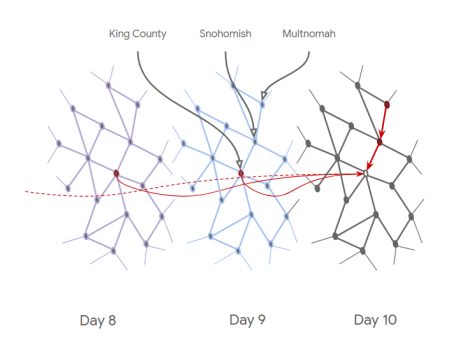

In [4]:
# There are 30 stations from 0-29
# Node for station s at timestamp i is (i*30 + s)

def generate_graph(df):
    
    #initialize empty graph
    G = nx.Graph()
    
    #loop over all the timestamps
    for time in df.time.unique():
        
        #Create Spatial Graph for this timestamp
        df_i = df[df['time'] == time]
        G_i = spatial_graph(df_i, time*30)
        
        #Add this graph to the overall graph
        G = nx.compose(G, G_i)
        
        #add temporal edges for each station
        for station in df_i.station_id:
            curr_node = time*30 + station

            for time_edge in range(time-1, time-8, -1):
                if time_edge < 0:
                    break
                prev_node = time_edge*30 + station
                G.add_edge(curr_node, prev_node, weight = 1)

        
    return G
        

# Create Graph

In [5]:
G = generate_graph(df)

In [6]:
G.edges(30)

EdgeDataView([(30, 0), (30, 31), (30, 32), (30, 33), (30, 34), (30, 35), (30, 36), (30, 37), (30, 38), (30, 39), (30, 40), (30, 41), (30, 42), (30, 43), (30, 44), (30, 45), (30, 46), (30, 47), (30, 48), (30, 49), (30, 50), (30, 51), (30, 52), (30, 53), (30, 54), (30, 55), (30, 56), (30, 57), (30, 58), (30, 59), (30, 60), (30, 90), (30, 120), (30, 150), (30, 180), (30, 210), (30, 240)])

# Create Pytorch-Geometric Data object

In [7]:
node_features = [(G.nodes[node]['humidity'], G.nodes[node]['wind_speed'], G.nodes[node]['wind_direction'], G.nodes[node]['temperature']) for node in G.nodes]

edge_weights = []
undirected_edges = []
for edge in G.edges:
    undirected_edges.append(edge)
    undirected_edges.append((edge[1], edge[0]))  # Add the reverse edge
    edge_weights.append(G.get_edge_data(edge[0], edge[1]))
    edge_weights.append(G.get_edge_data(edge[1], edge[0]))

edge_index = torch.tensor(list(G.edges)).t().contiguous()
y = torch.tensor([G.nodes[node]['pm'] for node in G.nodes], dtype=torch.float).view(-1, 1)
train_mask = torch.zeros(y.size(0), dtype=torch.bool)
test_mask = torch.zeros(y.size(0), dtype=torch.bool)

n_train = int(0.75*len(G.nodes))
n_train -= n_train%30

train_mask[:n_train] = True
test_mask[n_train:] = True

data = Data(x=torch.tensor(node_features, dtype=torch.float), edge_index=edge_index, edge_weight = edge_weights, y=y,train_mask=train_mask, test_mask=test_mask)

# Define the Model
The model consists of 4 layers:

i) Initial Embedding Layer(MLP)

ii) First GCN Layer(GCNConv)

iii) Second GCN Layer(GCNConv)

iv) Prediction Layer(MLP)

In [8]:
class InitialEmbedding(nn.Module):
    
    def __init__(self, input_dim):
        super().__init__()
        self.linear1 = nn.Linear(input_dim, 64)
        self.linear2 = nn.Linear(64, 32)
        
    def forward(self, x):
        x = self.linear1(x)
        x = F.relu(x)
        x = self.linear2(x)
        return x
  

class PredictionLayer(nn.Module):
    
    def __init__(self, input_dim):
        super().__init__()
        self.linear1 = nn.Linear(input_dim, 32)
        self.linear2 = nn.Linear(32, 1)
    
    def forward(self, x):
        x = self.linear1(x)
        x = F.relu(x)
        x = self.linear2(x)
        return x
        
class MainModel(nn.Module):
    
    def __init__(self, input_dim):
        super().__init__()
        self.mlp1 = InitialEmbedding(input_dim)
        self.conv1 = GCNConv(32, 32)
        self.conv2 = GCNConv(32, 32)
        self.mlp2 = PredictionLayer(32)
        self.dropout = nn.Dropout(p = 0.5)
        
    def forward(self, x, edge_index):
        #Initial Embedding
        x = self.mlp1(x)
        
        #First GCN Layer
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.dropout(x)
        
        #Second GCN Layer
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = self.dropout(x)
        
        #Prediction Layer
        x = self.mlp2(x)
        
        return x
        

# Train Model

100%|██████████████████████████████████████████████████████████████████████████████| 3000/3000 [03:26<00:00, 14.52it/s]


Train RMSE: 27.271032
Test RMSE: 16.642372


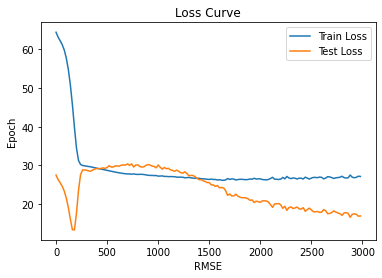

In [9]:
from tqdm import tqdm

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = MainModel(input_dim=4).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
criterion = nn.MSELoss()

train_rmse_list = []
test_rmse_list = []

for epoch in tqdm(range(3000)):
    optimizer.zero_grad()
    out = model(data.x.to(device), data.edge_index.to(device))
    loss = criterion(out[data.train_mask].squeeze(), data.y[data.train_mask].squeeze())
    loss.backward()
    optimizer.step()
    if(epoch%20==0):
        model.eval()
        with torch.no_grad():
            out = model(data.x.to(device), data.edge_index.to(device))  # Predicted PM values
            train_rmse = torch.sqrt(torch.mean((out[data.train_mask].squeeze() - data.y[data.train_mask].squeeze())**2))
            test_rmse = torch.sqrt(torch.mean((out[data.test_mask].squeeze() - data.y[data.test_mask].squeeze())**2))
            train_rmse_list.append(train_rmse.item())
            test_rmse_list.append(test_rmse.item())
        model.train()

model.eval()
with torch.no_grad():
    out = model(data.x.to(device), data.edge_index.to(device))  # Predicted PM values
    train_rmse = torch.sqrt(torch.mean((out[data.train_mask].squeeze() - data.y[data.train_mask].squeeze())**2))
    test_rmse = torch.sqrt(torch.mean((out[data.test_mask].squeeze() - data.y[data.test_mask].squeeze())**2))
    print("Train RMSE:", train_rmse.numpy())
    print("Test RMSE:", test_rmse.numpy())

plt.plot(range(0, 20*len(train_rmse_list), 20), train_rmse_list, label='Train Loss')
plt.plot(range(0, 20*len(test_rmse_list), 20), test_rmse_list, label='Test Loss')
plt.xlabel('RMSE')
plt.ylabel('Epoch')
plt.title('Loss Curve')
plt.legend()
plt.show()

# Get Predictions

In [10]:
preds = out[data.test_mask].squeeze().detach()
actual = data.y[data.test_mask].squeeze()

# Plot both train and test predictions Station-wise

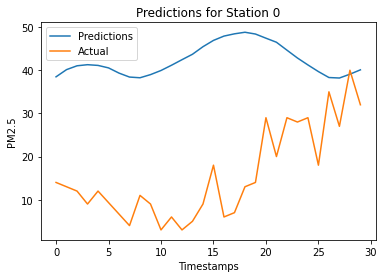

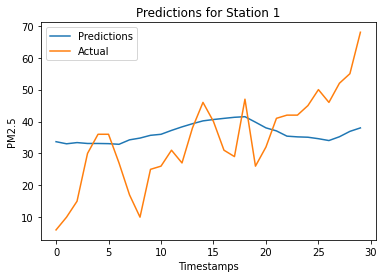

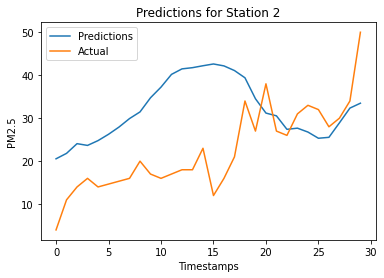

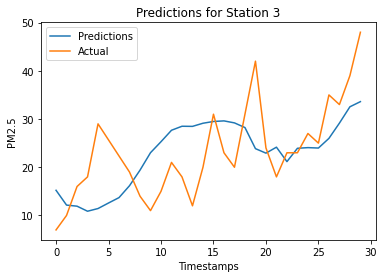

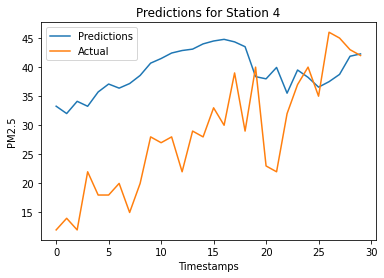

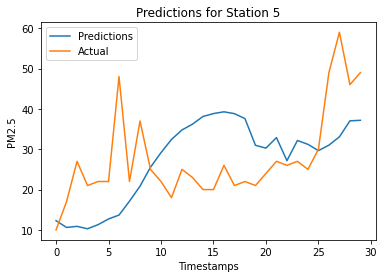

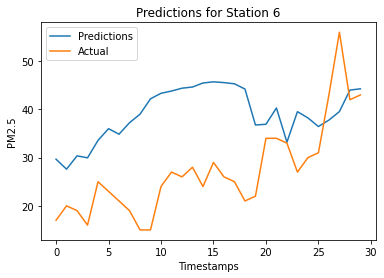

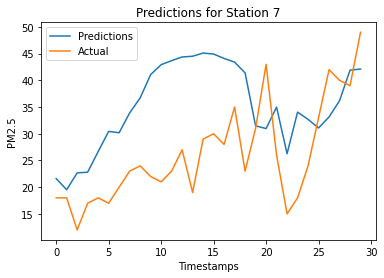

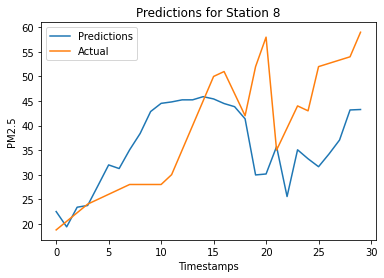

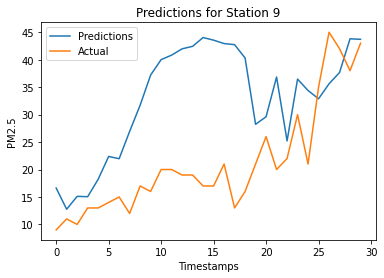

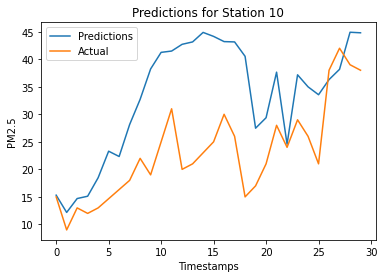

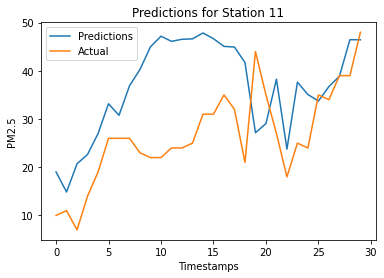

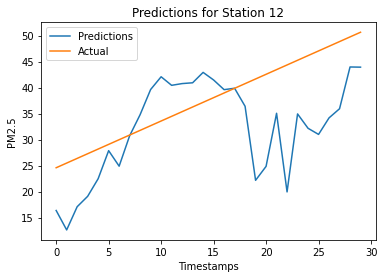

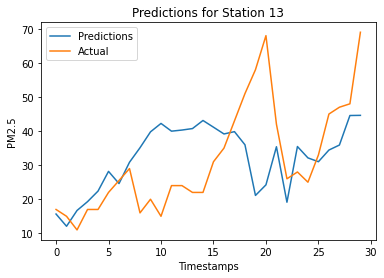

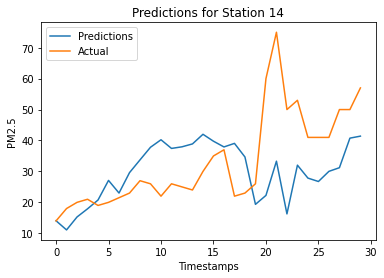

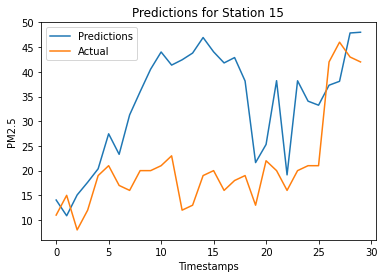

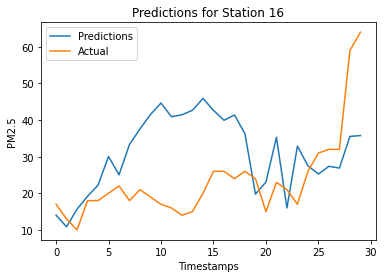

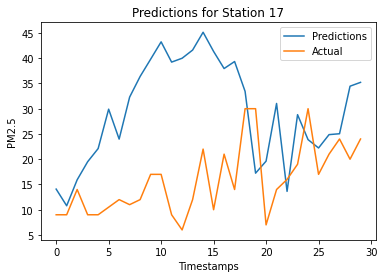

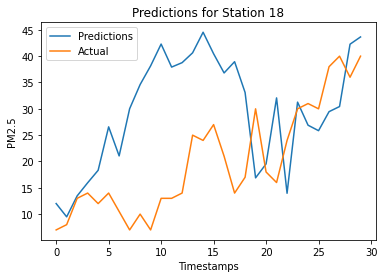

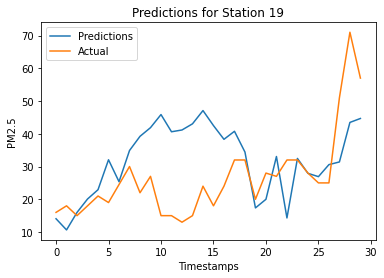

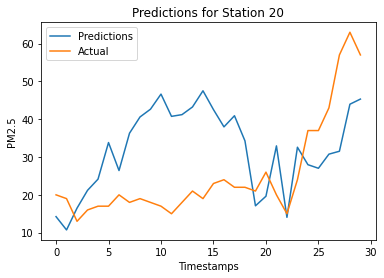

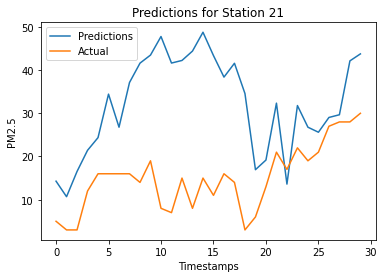

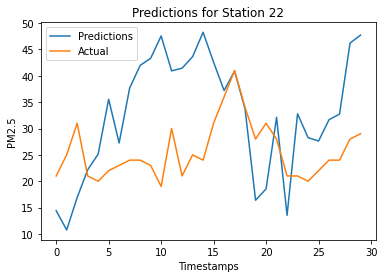

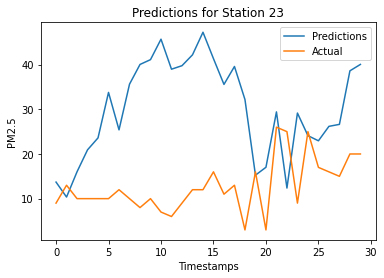

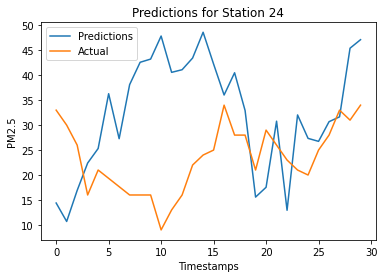

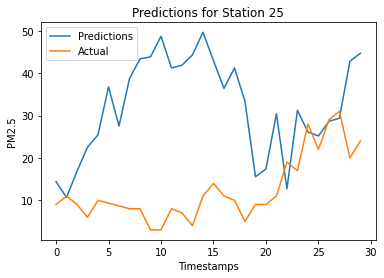

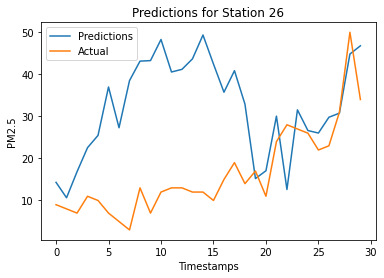

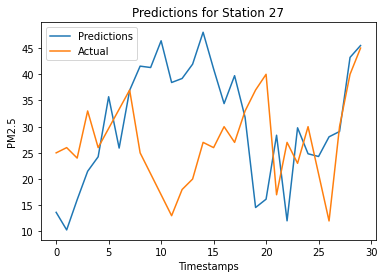

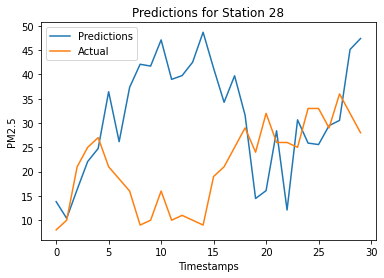

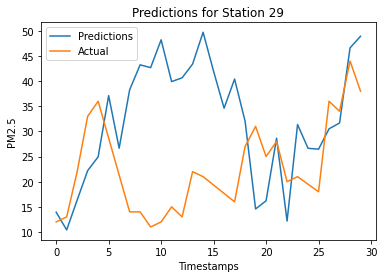

In [11]:
#Dictionaries for storing Predictions and Actual Values station-wise
station_preds = {}
station_actuals = {}

#Initialise empty lists for each station
for i in range(30):
    station_preds[i] = []
    station_actuals[i] = []

#Add predictions and actual values to dictionary
for i in range(0, len(preds), 30):
    for j in range(30):
        station_preds[j].append(preds[i+j])
        station_actuals[j].append(actual[i+j])

#Plot Predictions for Each Station
for i in range(30):
    plt.plot(station_preds[i], label = 'Predictions')
    plt.plot(station_actuals[i], label = 'Actual')
    plt.xlabel('Timestamps')
    plt.ylabel('PM2.5')
    plt.legend()
    title = 'Predictions for Station ' + str(i)
    plt.title(title)
    plt.show()

# Plot the test predictions

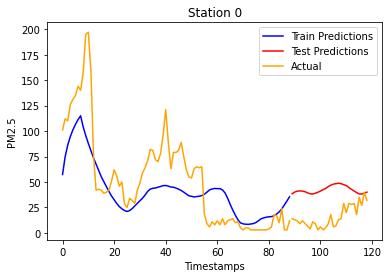

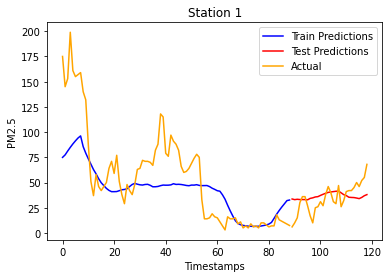

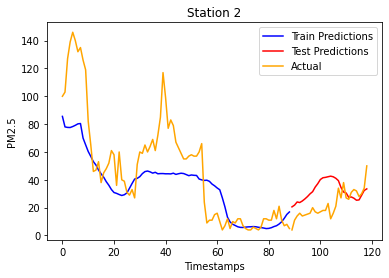

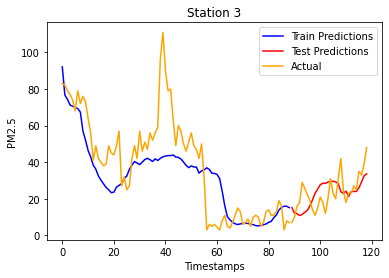

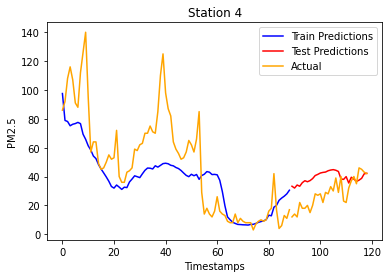

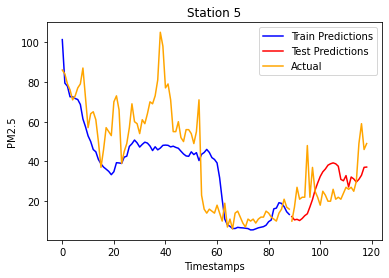

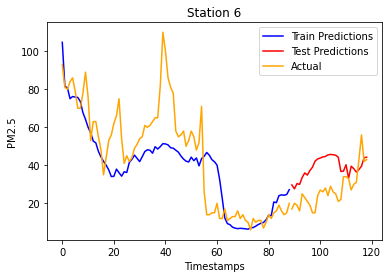

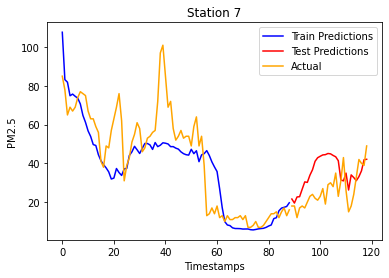

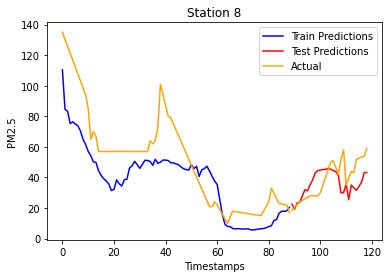

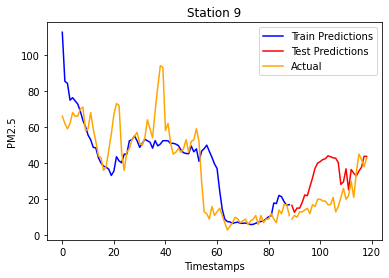

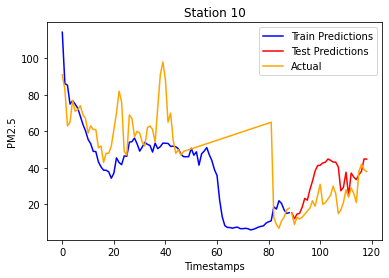

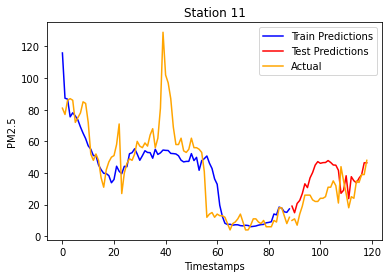

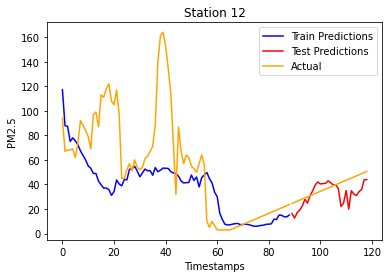

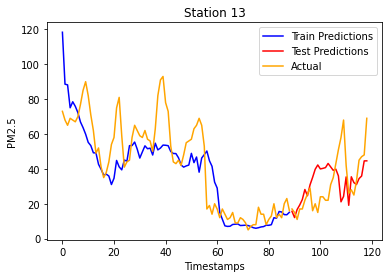

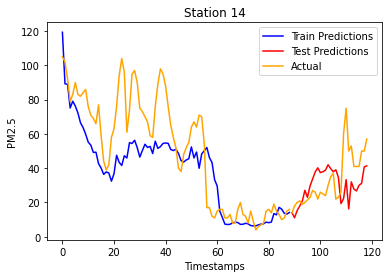

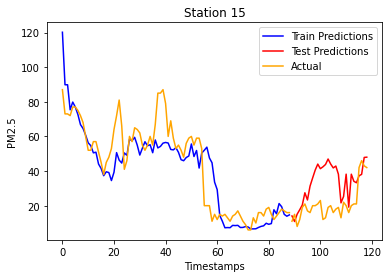

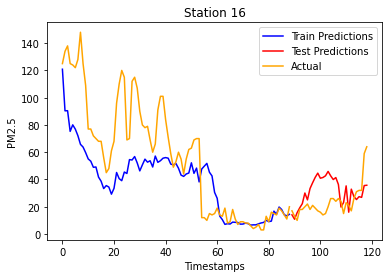

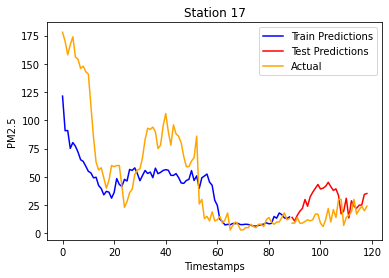

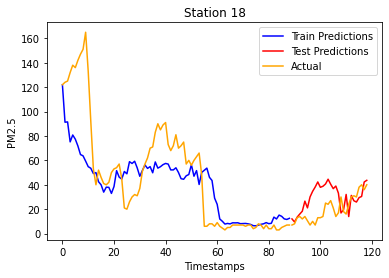

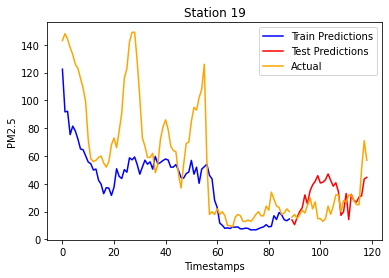

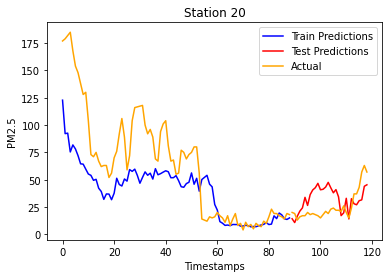

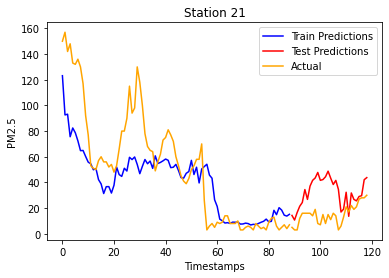

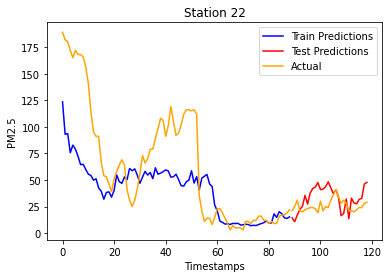

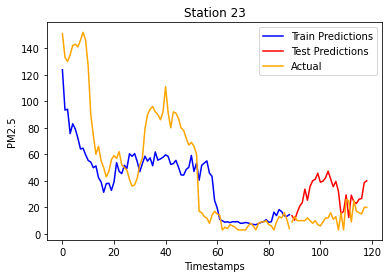

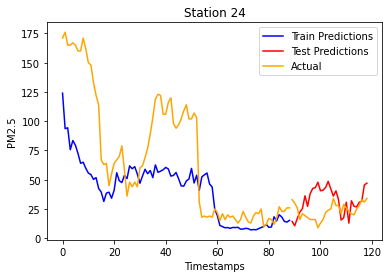

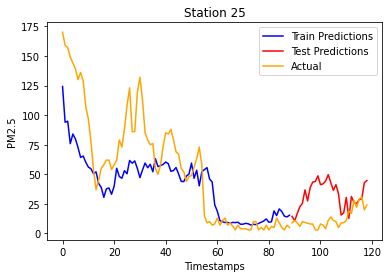

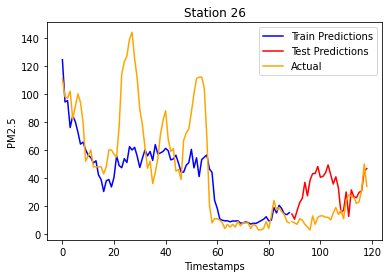

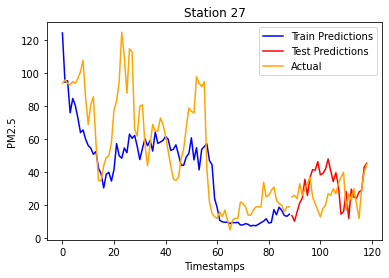

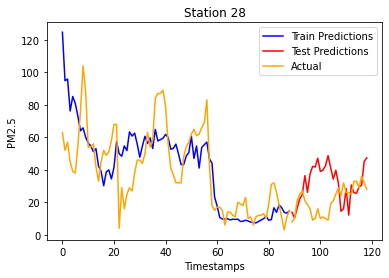

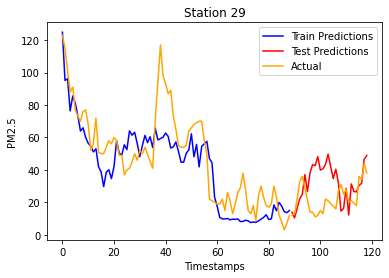

In [12]:
train_preds = out[data.train_mask].squeeze().detach()
train_actual = data.y[data.train_mask].squeeze()

train_stationwise_preds = {}
actual_stationwise_values = {}

for i in range(30):
    train_stationwise_preds[i] = []
    actual_stationwise_values[i] = []

for i in range(0, len(train_preds), 30):
    for j in range(30):
        train_stationwise_preds[j].append(train_preds[i+j])
        actual_stationwise_values[j].append(train_actual[i+j])

# Number of Timestamps in Training Data
n_ts = n_train//30

for i in range(30):
    plt.plot(range(n_ts), train_stationwise_preds[i], label = 'Train Predictions', color = 'blue')
    plt.plot(range(n_ts, n_ts+len(station_actuals[0])), station_preds[i], label = 'Test Predictions', color = 'red')
    plt.plot(range(n_ts), actual_stationwise_values[i], label = 'Actual', color = 'orange')
    plt.plot(range(n_ts, n_ts+len(station_actuals[0])), station_actuals[i], color = 'orange')
    plt.xlabel('Timestamps')
    plt.ylabel('PM2.5')
    plt.legend()
    title = 'Station ' + str(i)
    plt.title(title)
    plt.show()